# News Data Sentiment Classifier

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import dill
import re
from collections import Counter
from tqdm.notebook import tqdm, trange
import random

C:\Users\avila\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing `nltk`'s VADER Pre-trained Sentiment Classifier as a first working model.

In [2]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

STOP_WORDS = stopwords.words('english')

from nltk.sentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
# nltk.download('punkt')
SIA = SentimentIntensityAnalyzer()
# for scores, we call the SIA.polarity_scores method()

In [3]:
abbv_news = dill.load(open('ABBV.pkd', 'rb'))
adxs_news = dill.load(open('ADXS.pkd', 'rb'))
agen_news = dill.load(open('AGEN.pkd', 'rb'))
agio_news = dill.load(open('AGIO.pkd', 'rb'))
amgn_news = dill.load(open('AMGN.pkd', 'rb'))
aveo_news = dill.load(open('AVEO.pkd', 'rb'))
azn_news = dill.load(open('AZN.pkd', 'rb'))
bmy_news = dill.load(open('BMY.pkd', 'rb'))
clvs_news = dill.load(open('CLVS.pkd', 'rb'))
exel_news = dill.load(open('EXEL.pkd', 'rb'))

news = [abbv_news, adxs_news, agen_news, agio_news,
        amgn_news, aveo_news, azn_news, bmy_news, 
        clvs_news, exel_news]

companies = ["Abbvie Inc.", "Advaxis Inc.", "Agenus Inc.",
             "Agios Pharmaceutical Inc.", "Amgen Inc.",
             "Aveo Pharmaceuticals Inc.", "AstraZeneca PLC",
             "Bristol-Myers Squibb Co.", "Clovis Oncology Inc.",
             "Exelixis Inc."]

### Data Preprocessing

In [4]:
from string import punctuation
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
lem = WordNetLemmatizer()

def clean_title(text):
    """Removes the news format from text."""
    for news_type in {'News:', 'Press Release:'}:
        if news_type in text:
            return text.lstrip(news_type+' ')

def transformer(sentence):
    """Remove stop words and punctuation from sentence."""
    tokens = sentence.split(" ")
    tokens_filtered = [str(lem.lemmatize(word)).lower() for word in tokens if word.lower() not in (list(STOP_WORDS) or punctuation)]
    return (" ").join(tokens_filtered)

In [5]:
# combine all news into a single series
all_news = pd.concat([df.text for df in news], ignore_index=True)
# clean the news formats
all_news = all_news.apply(clean_title)
all_news = all_news.apply(transformer)
all_news

0        isankizumab (skyrizi®) demonstrates significan...
1        abbvie present 39th annual j.p. morgan healthc...
2        isankizumab (skyrizi®) phase 3 results demonst...
3        abbvie announces risankizumab demonstrates sig...
4        abbvie says risankizumab phase 3 results demon...
                               ...                        
17749    data presented aacr -- iaslc conference molecu...
17750                                  exelixis calls sold
17751    bio announces initial companies selected prese...
17752    exelixis announces january 12 webcast presenta...
17753    benzinga’s top pre- market losers (adsk, cnqr,...
Name: text, Length: 17754, dtype: object

#### Scoring Metrics

In [6]:
def region_score(score):
    """Takes in a polarity_scores dictionary."""
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    
    if neg < np.log(0.5*(pos+2)):
        return 1 # positive news
    elif (neg > np.log(0.5*(pos+2)) and neg < pos) or (neu <= 0.5):
        return 0 # neutral news
    elif neg > pos:
        return -1 # negative news
    return 0 # nill category news
     
    
def mixed_score(score):
    """Takes in a polarity_scores dictionary. Returns two scores; a
    concervative scoring and a bullish scoring"""
    x = score['compound']
    
    kinds = {'neutral': round(np.sin(0.5*np.pi*x)),
             'critical': round(2/(1+(1/3)**(50*x))-1)
            }
    
    return kinds

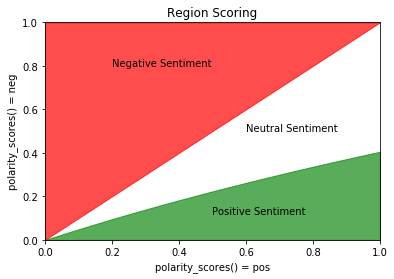

In [7]:
# =============================================================== #
# SIA.polarity_scores() outputs a dictionary of positive/negative
# sentiment. Apply region_scoring based on the following rule.
# Score determined by where (pos,neg) lands on the below diagram.
# =============================================================== #
x_arr = np.linspace(0,1)
plt.figure()
plt.title('Region Scoring')
plt.xlabel('polarity_scores() = pos')
plt.ylabel('polarity_scores() = neg')

plt.fill_between(x_arr, 1, x_arr, color='r', alpha=0.7)
plt.fill_between(x_arr, np.log(0.5*(x_arr+2)), color='green', alpha=0.65)
plt.axis([0,1,0,1])

plt.annotate('Negative Sentiment', (0.2,0.8))
plt.annotate('Neutral Sentiment', (0.6,0.5))
plt.annotate('Positive Sentiment', (0.5,0.12))

plt.show();

**Above:** `polarity_scores` method returns a dictionary of the form: 
```python
>>> {'neg': float, 'neu': float, 'pos': float, 'compound': float}
```
where `0 <= neg,neu,pos <= 1` and `neg+neu+pos = 1`. And calculated seperately, `-1 <= compound <= 1`.

The region scoring I suggest here consideres only the polarizing scores. It takes a tuple `(pos, neg)` generated from evaluating the sentiment of a headline and places it on the above graph.

The region of positive sentiment is intentionally smaller (21.6% of the picture), compared to negative sentiment (50%). It was assumed that stock prices in biotech are more sensitive to drops due to bad news than they are to increases due to good news. The remainder 28.3% given to neutral sentiment news should suggest holding the stock. **Note: the sizes of the region shouldn't be confused with the sentiment frequency of the news headlines.**

- Negative region is bigger because **bad news is worse than good news is good**. It also the least frequent sentiment so a good classifier responsible for informing trade descions should be sensitive to them.
- Regions don't correspond to the frquency of new headline sentiments. Otherwise the white region would be the largest (by far)
- The positive region is when it would be appealing to invest. Since it is the second most common sentiment, a good clasifier should be sensitive to "very good news" (eg. *"entering Phase 3", "successful completion", "acquired additional $300M in funding"*, etc.) rather than positive news as an umbrella category


<div>
<img src="sentiments.png" width="350">
Distribution of sentiments (1=Positive,0=Neutral,-1=Negative)
</div>

# Scoring, EDA & Feature Analysis

In [8]:
df = pd.DataFrame({'Headline': all_news})
df['region'] = pd.Series([region_score(SIA.polarity_scores(head))
                          for head in tqdm(all_news)])
for x in ['neutral', 'critical']:
    df[x] = pd.Series([mixed_score(SIA.polarity_scores(head))[x] 
                       for head in tqdm(all_news)])
df.head()

  0%|          | 0/17754 [00:00<?, ?it/s]

  0%|          | 0/17754 [00:00<?, ?it/s]

  0%|          | 0/17754 [00:00<?, ?it/s]

,Headline,region,neutral,critical
0,isankizumab (skyrizi®) demonstrates significan...,1,1,1
1,abbvie present 39th annual j.p. morgan healthc...,0,0,0
2,isankizumab (skyrizi®) phase 3 results demonst...,1,0,1
3,abbvie announces risankizumab demonstrates sig...,1,1,1
4,abbvie says risankizumab phase 3 results demon...,1,0,1


region  neutral  critical
 0       0        0          8650
 1       1        1          3376
         0        1          2116
-1      -1       -1          1618
         0       -1          1078
 0       0        1           448
        -1       -1           222
         0       -1           161
         1        1            77
-1       0        1             8
dtype: int64


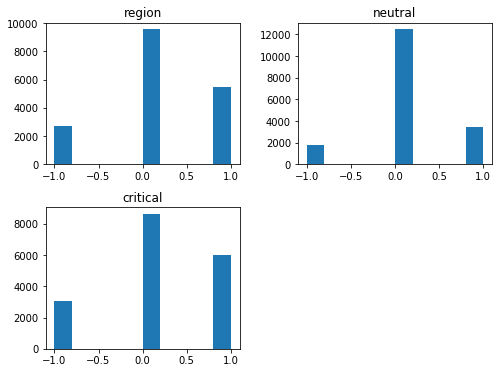

In [9]:
# Combinations of scoring on sentences
print(df[list(df.columns)[1:]].value_counts())
# Histogram of scoring distributions
df[list(df.columns)[1:]].hist(grid=False, figsize=(8,6));

In [10]:
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, QuadgramCollocationFinder

def list_of_words(sentences):
    """Takes in a pandas series of strings. Returns a list of all words
    in sentences (including repeated words)."""
    words_list = []
    for s in sentences:
        for word in s.split(" "):
            words_list.append(word)
    return words_list

bigram_finder = BigramCollocationFinder.from_words(list_of_words(all_news))
trigram_finder = TrigramCollocationFinder.from_words(list_of_words(all_news))
quadgram_finder = QuadgramCollocationFinder.from_words(list_of_words(all_news))

# Engineered feauture: most common pairs, triples, quads of words in headlines
DOUBLES = [ngram for (ngram,f) in bigram_finder.ngram_fd.most_common(300)]
TRIPLES = [ngram for (ngram,f) in trigram_finder.ngram_fd.most_common(200)]
QUADS = [ngram for (ngram,f) in quadgram_finder.ngram_fd.most_common(100)]

Changes Made:

- Fixed the logic in the transformer function
- Feature Engineering
- Trained a `NaiveBayesClassifier`
    - do a binary sentiment classification of headlines
- Use a split of the sentences that scored `(111)` or `(-1-1-1)` as the train set
    - Test model on the `(111)` and `(-1-1-1)` headlines
- Classify all other headlines

In [44]:
filenames = ['common_adjectives.csv', 'common_adverbs.csv',
             'common_nouns.csv', 'common_verbs.csv', 'random_words.csv']

# sentiment truths
word_truths = pd.concat([pd.read_csv(file) for file in filenames],
                        ignore_index=True)

POSITIVE_WORDS = word_truths[word_truths.Sentiment == 1].Word.unique()
NEGATIVE_WORDS = word_truths[word_truths.Sentiment == -1].Word.unique()
NEUTRAL_WORDS = word_truths[word_truths.Sentiment == 0].Word.unique()

from nltk.tokenize import word_tokenize

def sentiment_features(sentence):
    cleaned = set(transformer(sentence).split(" "))
    feats = {}
    feats['pos'] = len(cleaned.intersection(set(POSITIVE_WORDS)))
    feats['neg'] = len(cleaned.intersection(set(NEGATIVE_WORDS)))
    feats['neu'] = len(cleaned.intersection(set(NEUTRAL_WORDS)))
    feats['bi'], feats['tri'], feats['quad'] = (False, False, False)
    for (i,j) in DOUBLES:
        if i+" "+j in sentence:
            feats['bi'] = True
    for (i,j,k) in TRIPLES:
        if i+" "+j+" "+k in sentence:
            feats['tri'] = True
    for (i,j,k,l) in QUADS:
        if i+" "+j+" "+k+" "+l in sentence:
            feats['quad'] = True
    
    feats['balance'] = feats['pos'] - feats['neg']
    
    return feats

P_INDICES = list(df[(df.region == df.critical) & (df.neutral == 1)].index)
N_INDICES = list(df[(df.region == df.critical) & (df.neutral == -1)].index)

positive_headlines = all_news.iloc[P_INDICES]
negative_headlines = all_news.iloc[N_INDICES]

all_headlines = ([(sent, 'pos') for sent in positive_headlines] +
                 [(sent, 'neg') for sent in negative_headlines])

In [48]:
np.random.RandomState(123)
random.shuffle(all_headlines, random=None)
featuresets = [(sentiment_features(words),senti) for (words,senti) in all_headlines]

size = len(featuresets)
# training on about 85% of the data, test on 15%
train_set, test_set = featuresets[int(size/1.18):], featuresets[:int(size/1.18)]

clf = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(clf, test_set))

0.7093572778827977


In [49]:
clf.show_most_informative_features(10)

Most Informative Features
                 balance = -2                neg : pos    =      6.3 : 1.0
                     neg = 3                 neg : pos    =      5.0 : 1.0
                 balance = -3                neg : pos    =      4.9 : 1.0
                 balance = 5                 pos : neg    =      3.7 : 1.0
                 balance = 4                 pos : neg    =      3.7 : 1.0
                 balance = -1                neg : pos    =      3.2 : 1.0
                     neg = 0                 pos : neg    =      3.1 : 1.0
                     neg = 1                 neg : pos    =      2.6 : 1.0
                     neg = 4                 neg : pos    =      2.2 : 1.0
                     neg = 2                 neg : pos    =      2.1 : 1.0


In [68]:
# all other indices that were not (111) or (-1-1-1)
O_INDICES = list(set(np.arange(len(all_news))).difference(set(P_INDICES+N_INDICES)))

pred = pd.Series([clf.classify(sentiment_features(h)) for h in all_news.iloc[O_INDICES]],
                 index=O_INDICES)
pred = pd.concat([pred,
                  pd.Series('pos', index=P_INDICES),
                  pd.Series('neg', index=N_INDICES)]
                ).sort_index()

In [107]:
df['Binary_Prediction'] = pred
df[['Headline','Binary_Prediction']].tail()

,Headline,Binary_Prediction
17749,data presented aacr -- iaslc conference molecu...,neg
17750,exelixis calls sold,pos
17751,bio announces initial companies selected prese...,pos
17752,exelixis announces january 12 webcast presenta...,pos
17753,"benzinga’s top pre- market losers (adsk, cnqr,...",neg


# After Notes:

### Accuracy

The classifier here achieved a testing accuracy of about 71%.

After reshuffling the `train_set` and re-training the classifier 140 times, the average accuracy was $0.71177\pm 0.00488$. This was done on an 85/15 split (training/test ratio) of the data.

Afterwards, I allowed the train-test-split to vary from 25/75 up to 85/15 and repeating this re-training process each time 140 times. The centroid of this data was an accuracy score $0.71316\pm 0.00520$.

Since the language in most of these headlines is scinetific or economic in nature, the classifier really struggles to determine positivity/negativity from the jargon. The diseases which the pharmaceuticals aim to cure are often in the headline and these appear to hold a negative context

Ways to increase the accuracy:
1. **Improve the training data.** Here, I improvised a training set from results of a general, pre-trained NLP classifier that was not specialized for this task.
    - Someone with a little bit of background in medicne and finance reads a few thousand (ideally ~10,000) of these headlines and manually scores them `-1`, `0`, or `1`. **(Most needed improvement)**
    - Compile a list of jargon which could convey positive/negative sentiment. For example: "call vs put"
2. **Train multiple classifiers and compare, or even mix & match models.** I was also going to train a `DecisionTreeClassifier` but without an informed `train_set`, it wouldn't be very insightful.
3. **Train a classifier that can handle non-binary results.** I suspect a large problem faced by the model is the lack of degrees of `pos/neg`. A simple good-bad output destroys some of the information we are ultimately after--very good news. Since we would want to invest in companies which have "VERY GOOD" news not, just kind of good news.
4. **Change the approach that the classifier takes.** Rather than target good-bad news, approach the problem as: "Success=Very Good news, Failure= Everything else". This way, we exclusively isolate the best news indicating a breakthrough or success in the clinical trial to signal to start buying before other traders.
    - This needs suggestion 1 to be completed first or else, the model will not know what VERY GOOD is.

### Math/Stats

The `train_set`+`test_set` is comprised of 4994 news headlines which have been already sorted into positive (3376) and negative (1618).

<div>
<img src="traintest.png" width="400">
</div>

On the 749 test headlines, the classifier achieved a success rate of 0.709. I use this as the probability of successfully classifying a headline in the unclassified dataset with all of the collected news headlines. Since we had 17,753 headlines to classify in the dataset, the Binomial distribution describing the number of successful classifications can be well-approximated by a Gaussian distribution.

$$X\sim\mathrm{Binomial}(17754,0.709) \longrightarrow X\sim\mathrm{N}(12587.586,\sqrt{3662.987526})$$


A 1% change in the accuracy of predictions amounts to a $2.93\sigma$ deviation. We can reasonably expect the classifier to accurately classify between $12406$ and $12769$ headlines.

Taking a look at the top ten most informative features, the most informative is the `balance = -2` feature. This is when there are 2 more negative words in the headline than positive words. This results in the odds of being a negative sentiment sentence are $6.3$ to $1$. The second most informative feature is when there are exactly 3 recognized negative words in the headline. The odds of being bad new are then $5$ to $1$.
- The probability of success is not uniformly 0.709 for any given sentence. The classifier is stronger on headlines that follow certain patterns like these.
- The classifier is more confident in identifying bad news than it is in classifying good news. 

### Conclusion

This NLP model is not useful for saying when it is a good time to buy, and beat the wave of investors. It instead tells you when news is bad, indicating that it might be good to sell before others start selling shares.